# Chapter 4: Time Series Features

In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

In [2]:
import tsfeatures as tsf
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mpl.rcParams['axes.prop_cycle'] = cycler(color=["#D55F03", "#569CC6", "#13A076", "#CC79A7"])

The `tsfeatures` package (Python equivalent of the R packages by the same name) allows us to calculate various features from time series data. 

We'll use Australian quarterly tourism as a running example in this chapter. 

## 4.1 Some simple statistics 

Any numerical summary computed from a time series is a feature of that time series. For example, we can compute the means of each series in the Australian tourism data:

In [3]:
aus_tourism = pd.read_csv("./data/aus_tourism.csv", parse_dates=["ds"])
mean_df = aus_tourism.groupby("unique_id", as_index=False)["y"].mean()
mean_df.sort_values(by="y").head(10)

,unique_id,y
158,Kangaroo Island-South Australia-Other,0.340
182,MacDonnell-Northern Territory-Other,0.449
294,Wilderness West-Tasmania-Other,0.478
34,Barkly-Northern Territory-Other,0.632
86,Clare Valley-South Australia-Other,0.898
38,Barossa-South Australia-Other,1.022
154,Kakadu Arnhem-Northern Territory-Other,1.043
170,Lasseter-Northern Territory-Other,1.136
298,Wimmera-Victoria-Other,1.146
183,MacDonnell-Northern Territory-Visiting,1.175


Now five summary statistics (min, max, quartiles):

In [4]:
summary_stats = tsf.tsfeatures(aus_tourism, freq=4, features=[tsf.statistics], scale=False)
summary_stats[["unique_id", "min", "p25", "median", "p75", "max"]].head(10)

,unique_id,min,p25,median,p75,max
0,Adelaide Hills-South Australia-Business,0.000,0.000,1.255,3.920,28.602
1,Adelaide Hills-South Australia-Holiday,0.000,5.768,8.516,14.060,35.751
2,Adelaide Hills-South Australia-Other,0.000,0.000,0.908,2.093,8.953
3,Adelaide Hills-South Australia-Visiting,0.778,8.908,12.207,16.806,81.102
4,Adelaide-South Australia-Business,68.725,133.893,152.577,176.936,242.494
5,Adelaide-South Australia-Holiday,108.033,134.627,153.945,172.257,223.557
6,Adelaide-South Australia-Other,25.902,43.866,53.809,62.523,107.495
7,Adelaide-South Australia-Visiting,136.611,178.916,205.582,229.299,269.536
8,Alice Springs-Northern Territory-Business,1.008,9.133,13.324,18.456,34.077
9,Alice Springs-Northern Territory-Holiday,2.809,16.851,31.524,44.784,76.541


## 4.2 ACF Features

Autocorrelations can be considered features of a series. We can also combine autocorrelations to produce new features, e.g. the sum of the first ten squared autocorrelation coefficients is a useful summary of how much autocorrelation there is in a series. 

We can also compute the differences between consecutive observations and compute autocorrelations of the differenced series. 

Another approach is to compute seasonal differences of a series, e.g. for monthly data compute the difference between consecutive Januaries, consecutive Februaries, etc. 

Setting `features=[acf_features]` in `tsf.tsfeatures()` computes:
- the first autocorrelation coefficient from the original data
- the sum of squares of the first ten autocorrelation coefficients from the original data
- the first autocorrelation coefficient of the differenced data
- the sum of squares of the first ten autocorrelation coefficients from the differenced data
- the first autocorrelation coefficient from the twice differenced data
- the sum of squares of the first ten autocorrelation coefficients from the twice differenced data
- for seasonal data, the autocorrelation coefficient at the first seasonal lag 

In [5]:
acf_feat = tsf.tsfeatures(aus_tourism, freq=4, features=[tsf.acf_features])
acf_feat.head(10).iloc[:, :5]

,unique_id,x_acf1,x_acf10,diff1_acf1,diff1_acf10
0,Adelaide Hills-South Australia-Business,0.071,0.134,-0.580,0.415
1,Adelaide Hills-South Australia-Holiday,0.131,0.313,-0.536,0.500
2,Adelaide Hills-South Australia-Other,0.261,0.330,-0.253,0.317
3,Adelaide Hills-South Australia-Visiting,0.139,0.117,-0.472,0.239
4,Adelaide-South Australia-Business,0.033,0.131,-0.520,0.463
5,Adelaide-South Australia-Holiday,0.046,0.372,-0.343,0.614
6,Adelaide-South Australia-Other,0.517,1.154,-0.409,0.383
7,Adelaide-South Australia-Visiting,0.068,0.294,-0.394,0.452
8,Alice Springs-Northern Territory-Business,0.217,0.367,-0.500,0.381
9,Alice Springs-Northern Territory-Holiday,-0.007,2.113,-0.153,2.113


# 4.3 STL Features

Recall the decomposition $$ y_t = T_t + S_t + R_t$$ consisting of the trend-cycle, seasonal, and remainder components. For strongly trended data, the seasonally adjusted data $T_t + R_t$ should have much more variation than the remainder component, so $$\frac{\text{Var}(R_t)}{\text{Var}(T_t + R_t)}$$ should be relatively small. For data with little or no trend, the two variances should be approximately the same. So we define strength of trend as $$ F_T = \max(0, 1-\frac{\text{Var}(R_t)}{\text{Var}(T_t + R_t)}). $$

The strength of seasonality is defined analagously, but w.r.t the detrended data $S_t + R_t$: $$F_T = \max(0, 1-\frac{\text{Var}(R_t)}{\text{Var}(S_t + R_t)}). $$

A series with seasonal strength $F_s$ close to 0 exhibits almost no seasonality. 

These and other STL-based features are computed using `features=[stl_features]`:

In [6]:
stl_feat = tsf.tsfeatures(aus_tourism, freq=4, features=[tsf.stl_features])
stl_feat.head(10).iloc[:, :5]

,unique_id,nperiods,seasonal_period,trend,spike
0,Adelaide Hills-South Australia-Business,1,4,0.460,3.223e-04
1,Adelaide Hills-South Australia-Holiday,1,4,0.531,1.048e-04
2,Adelaide Hills-South Australia-Other,1,4,0.590,5.346e-05
3,Adelaide Hills-South Australia-Visiting,1,4,0.487,5.798e-04
4,Adelaide-South Australia-Business,1,4,0.462,9.712e-05
5,Adelaide-South Australia-Holiday,1,4,0.578,1.717e-05
6,Adelaide-South Australia-Other,1,4,0.746,2.364e-05
7,Adelaide-South Australia-Visiting,1,4,0.449,4.824e-05
8,Alice Springs-Northern Territory-Business,1,4,0.552,5.246e-05
9,Alice Springs-Northern Territory-Holiday,1,4,0.379,6.707e-06


We can use these features in plots to identify what type of series are heavily trended and what are most seasonal:

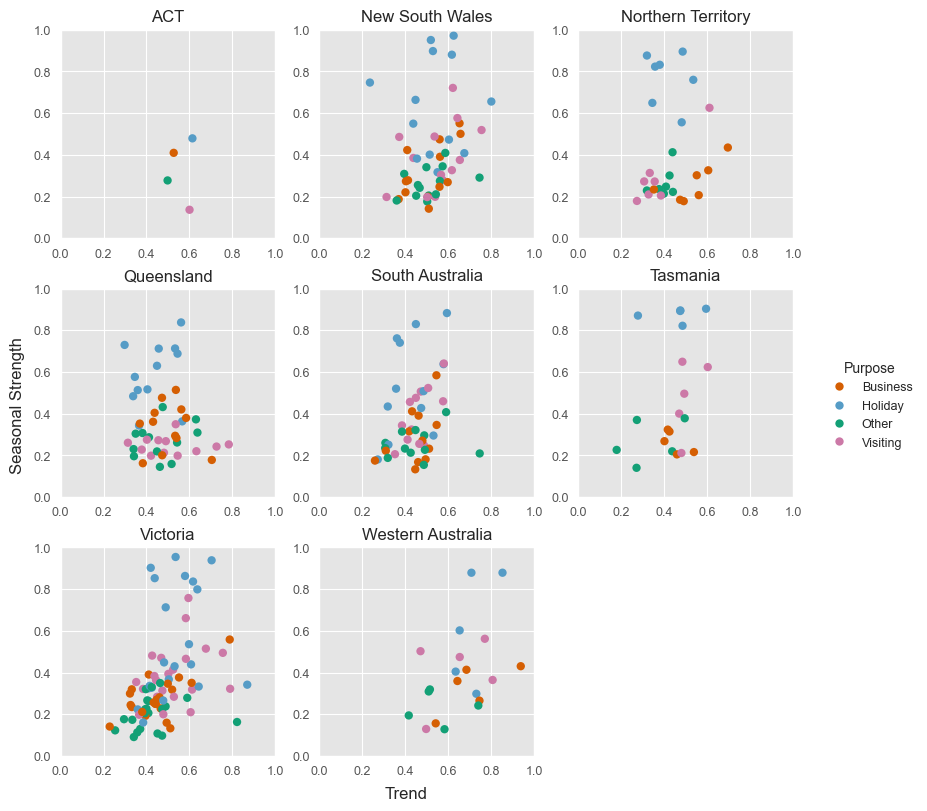

In [ ]:
df = (
    stl_feat["unique_id"].str.split("-", expand=True)
    .rename(columns={0: "region", 1: "state", 2: "purpose"})
    .join(stl_feat)
)

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
axs = axs.flatten()
for ax, (state, state_df) in zip(axs, df.groupby('state')):
    sns.scatterplot(x="trend", y="seasonal_strength", hue="purpose", edgecolor="none", data=state_df, ax=ax)
    ax.get_legend().remove()
    ax.set(title=state, xlabel="", ylabel="", xlim=(0, 1), ylim=(0, 1))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
    title="Purpose", loc="center left", frameon=False,
    bbox_to_anchor=(1.02, .5), borderaxespad=0)

fig.supxlabel('Trend')
fig.supylabel('Seasonal Strength')

# Remove any empty subplots
for ax in axs:
    if not ax.lines:
        ax.set_visible(False)

From this we see that holiday series are highly seasonal, which makes sense. The strongest trends tend to be in Victoria and Western Australia.

We can plot the most seasonal series below.

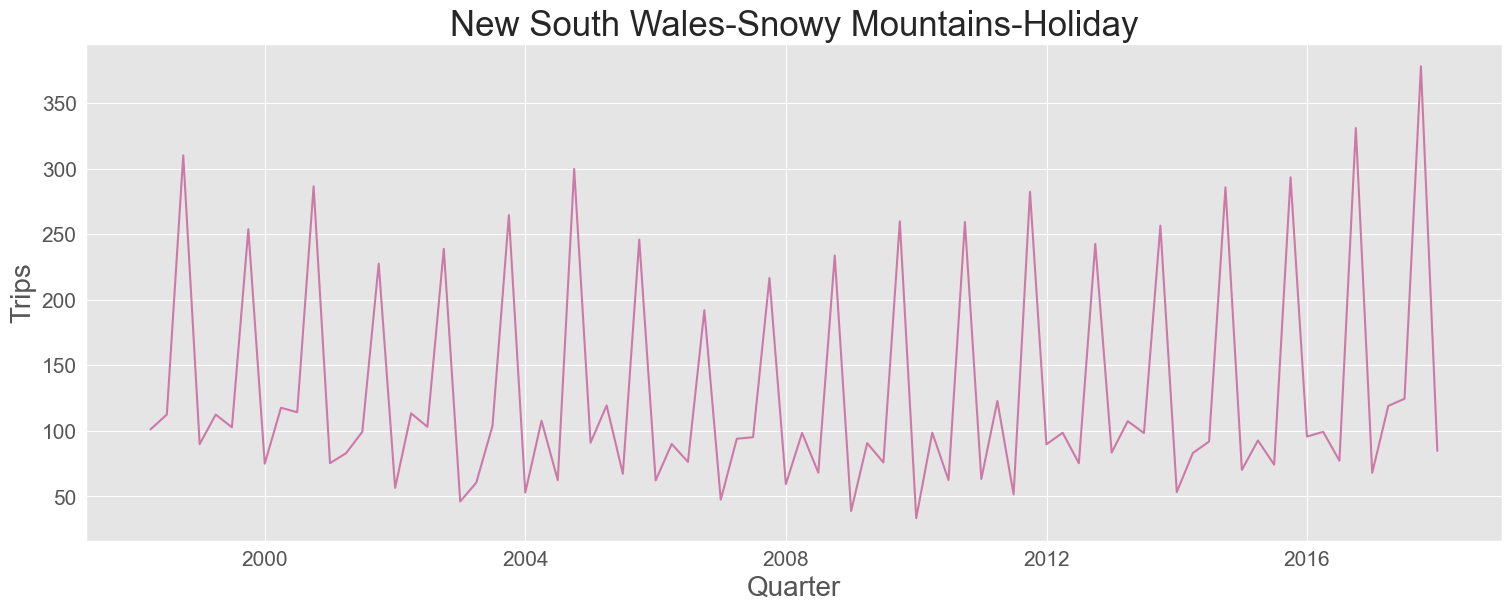

In [8]:
row = stl_feat.loc[lambda x: x["seasonal_strength"].idxmax()]
plot_series(
    aus_tourism, ids=[row["unique_id"]],
    xlabel="Quarter", ylabel="Trips",
    title="New South Wales-Snowy Mountains-Holiday")

This shows holiday trips to the most popular ski region of Australia. 

`stl_features()` also returns:
- `peak`/`trough` indicating the timing of the peaks/troughs---which month/quarter contains the largest/smallest seasonal component. 
- `spike` measures the spikes in the remained component of the STL decomposition. it's the variance of the leave-one-out-variances of $R_t$
- `linearity` measures the linearity of the trend component and is based on the coefficient of a linear regression applied to the trend component
- `curvature` measures the curvature of the trend component and is based on the coefficient from an orthogonal quadratic regresion applied to the trend component
- `e_acf1` is the first autocorrelation coefficient of the remainder series
- `e_acf10` is the sum of squares of the first ten autocorrelation coefficients of the remainder series

## 4.4 Other features

Remaining features in the `tsfeatures` library:
- `hurst`: Hurst coefficient, measure of "long memory"
- `feat_spectral`: Shannon spectral entropy, measure of how easy the series is to forecast. A noisy series will have entropy close to 1. 
- `box_pierce` for testing if a time series is white noise and the corresponding p-value
- `ljung_box` for testing if a time series is white noise and the corresponding p-value
- the $k$th partial autocorrelation measures the relationship between observations $k$ steps apart after removing the effects of observations between them
- `n_crossing_points` is the number of times the series crosses the median
- `stat_arch_lm` returns the statistic based on the Lagrange multiplied test of Engle for autoregressive conditional heteroscedasticity (ARCH)
- `guerrero` computes the optimal $\lambda$ for a Box-Cox transformation

## 4.5 Exploring Australian Tourism data

Compute all features included in the `tsfeatures` library:

In [9]:
all_features = [
    tsf.acf_features,
    tsf.arch_stat,
    tsf.crossing_points,
    tsf.entropy,
    tsf.flat_spots,
    tsf.heterogeneity,
    tsf.holt_parameters,
    tsf.lumpiness,
    tsf.nonlinearity,
    tsf.pacf_features,
    tsf.stl_features,
    tsf.stability,
    tsf.hw_parameters,
    tsf.unitroot_kpss,
    tsf.unitroot_pp,
    tsf.series_length,
    tsf.hurst,
]
all_feat = tsf.tsfeatures(aus_tourism, freq=4, features=all_features)
all_feat.head(10)

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Adelaide Hills-South Australia-Business,NaN,80,-80.527,0.060,1.490e-08,1.220e-08,0.00,0.294,1,...,0.895,36,0.014,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063
1,Adelaide Hills-South Australia-Holiday,0.823,80,-74.302,0.476,9.899e-02,9.899e-02,0.00,0.409,1,...,0.831,33,0.121,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208
2,Adelaide Hills-South Australia-Other,0.599,80,-55.385,0.605,1.490e-08,1.481e-08,0.18,0.274,1,...,0.862,37,0.265,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075
3,Adelaide Hills-South Australia-Visiting,0.757,80,-71.076,0.749,1.490e-08,1.150e-09,0.00,0.333,1,...,0.907,25,0.005,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170
4,Adelaide-South Australia-Business,0.840,80,-78.764,0.221,1.306e-01,1.306e-01,0.00,0.318,1,...,0.848,43,0.183,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201
5,Adelaide-South Australia-Holiday,0.709,80,-72.567,0.449,1.758e-01,1.758e-01,0.00,0.312,1,...,0.737,36,0.161,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351
6,Adelaide-South Australia-Other,0.776,80,-36.405,1.406,1.068e-01,7.715e-02,0.00,0.574,1,...,0.755,28,0.456,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342
7,Adelaide-South Australia-Visiting,0.737,80,-74.137,0.264,1.630e-01,0.000e+00,0.00,0.267,1,...,0.776,42,0.173,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345
8,Alice Springs-Northern Territory-Business,0.673,80,-65.845,0.807,1.456e-01,0.000e+00,0.00,0.439,1,...,0.851,33,0.425,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315
9,Alice Springs-Northern Territory-Holiday,0.579,80,-54.382,0.387,1.490e-08,7.912e-09,0.00,0.084,1,...,0.412,40,0.304,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729


This essentially gives 42 features for each combination of the three key variables: Region-State-Purpose.

Similarly to how we plotted seasonality against trend in Section 4.3, we can do pairwise plots of groups of features. Below we look at all features that involve seasonality, along with the `Purpose` variable, which is mapped to color. 

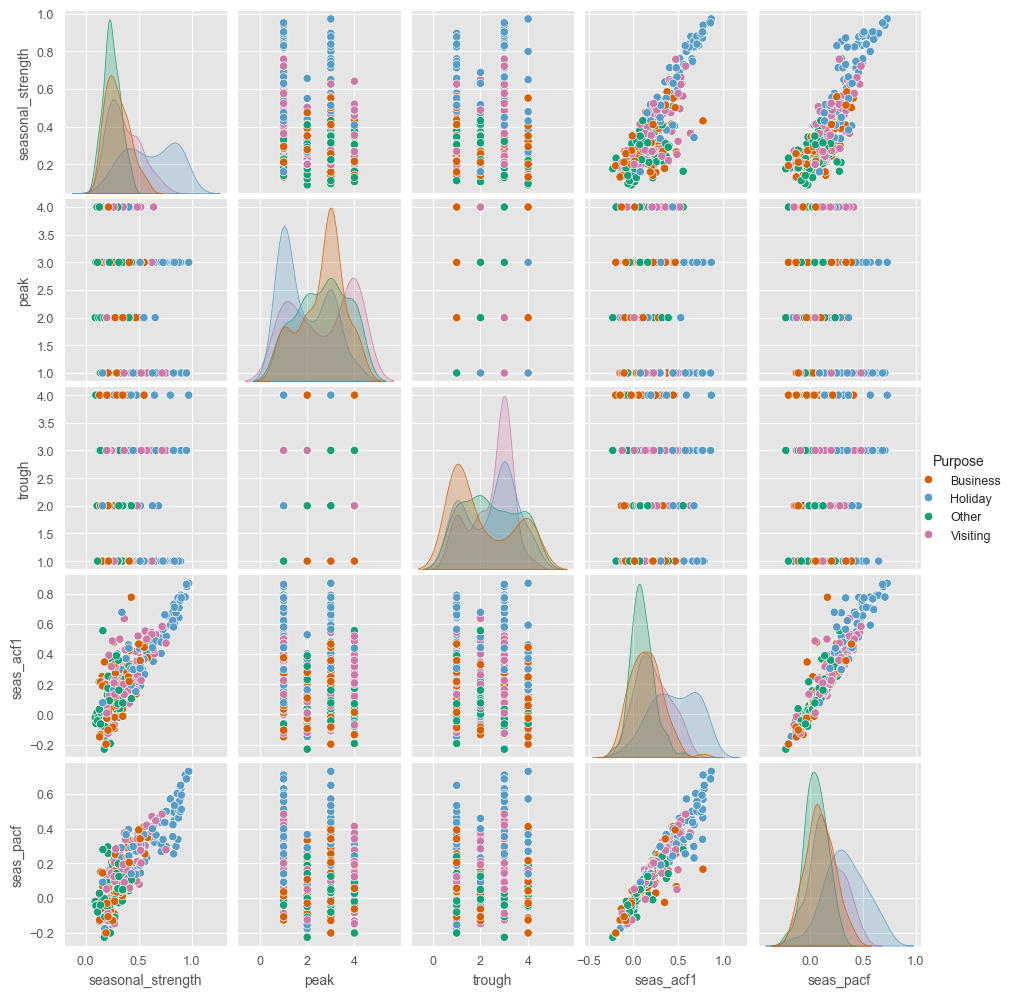

In [10]:
seasonal_feat = all_feat[
    ["unique_id", "seasonal_strength", "peak", "trough",
     "seas_acf1", "seas_pacf"]
]

df = (
    seasonal_feat["unique_id"].str.split("-", expand=True)
    .rename(columns={0: "region", 1: "state", 2: "Purpose"})
    .join(seasonal_feat)
)
g = sns.pairplot(df, hue="Purpose")
g.fig.set_size_inches(10, 10)
plt.show()

Some things we can learn from the above figure:
- the three numerical measures related to seasonality (`seasonal_strength`, `season_acf1`, and `season_pacf`) are all positively correlated. 
- the bottom left and top right panel all show that the most strongly seasonal series are related to holidays
- the bar plots in the bottom row of the peak and trough columns show that seasonal peaks in Business travel occur most often in Q3, and least often in Q1

It's difficult to explore more than a handful of variables this way. A useful way to handle more variables is to reduce dimensions using e.g. principal components, which give linear combinations of variables that explain the most variation in the original data. The principal components of tourism features are as follows. 

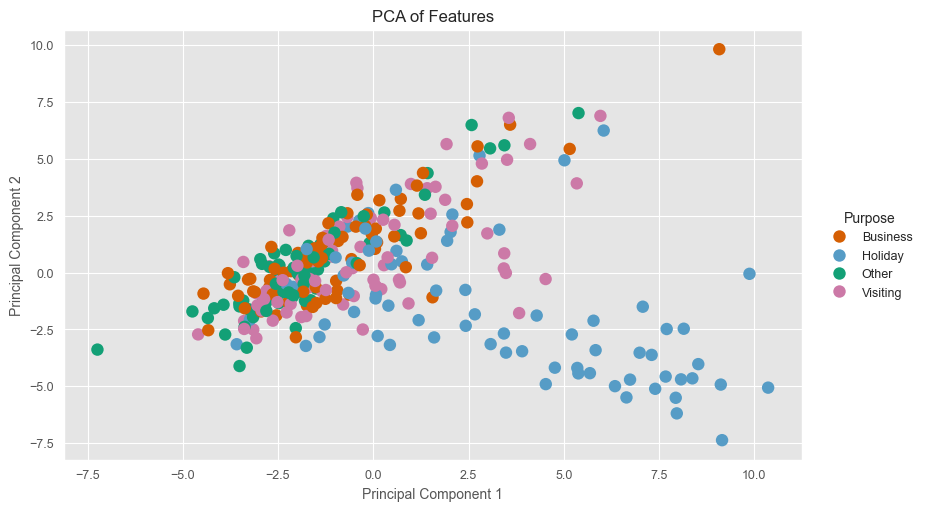

In [11]:
df = (
    all_feat
    .assign(purpose=lambda x: x["unique_id"].str.split("-").str[-1])
    .dropna(axis='columns')
)
X = df.drop(columns=["unique_id", "purpose"])

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=2)),
])
principal_components = pipeline.fit_transform(X)

pca_df = (
    pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])
    .join(df[["unique_id", "purpose"]])
)

fig, ax = plt.subplots()
sns.scatterplot(x="PC1", y="PC2", s=80,
    hue="purpose", edgecolor="none", data=pca_df, ax=ax)
ax.set(
    title="PCA of Features",
    xlabel="Principal Component 1",
    ylabel="Principal Component 2",
)
ax.get_legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
    title="Purpose", loc="center left", frameon=False,
    bbox_to_anchor=(1.02, .5), borderaxespad=0)
plt.show()

Each point in the above plot represents one series and its coordinates are based on all 37 features. The first principal component is the linear combination of features which explains the most variation in the data. The second PC is the linear combination which explains the next most variation in the data, while being uncorrelated with the first PC.

The PCA plot reveals that holiday series behave differently from other series, and clearly the second principal component is distinguishing between holidays and other types of travel. 

There are also three anomalous series that appear as outliers to the rest of the cluster, and we can identify them as follows. 

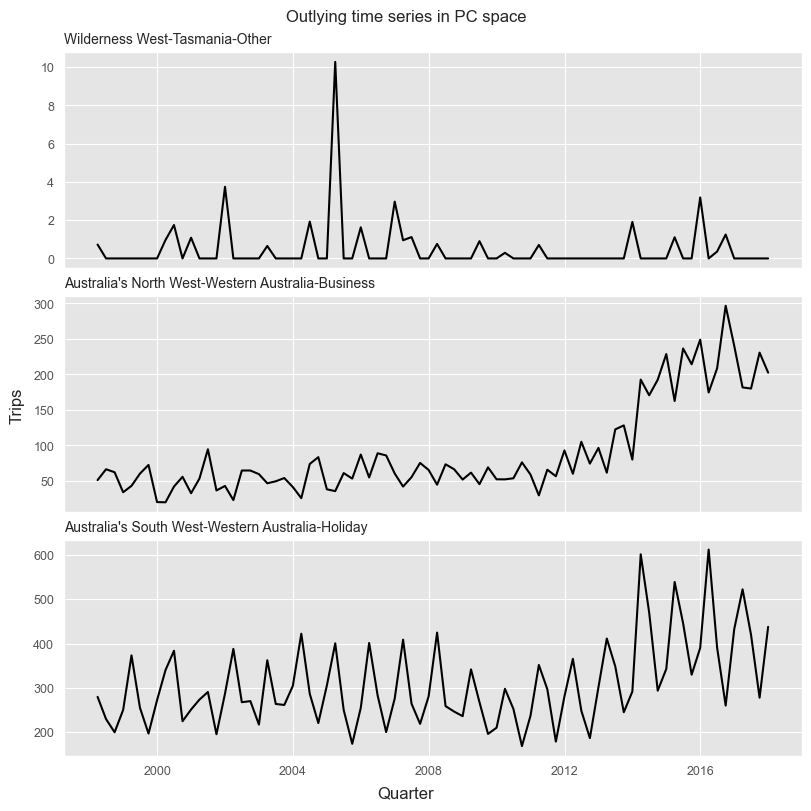

In [12]:
lof = LocalOutlierFactor(n_neighbors=10).fit(pca_df[["PC1", "PC2"]])
res = pca_df.assign(score=lof.negative_outlier_factor_)
selected_ids = res.sort_values("score")["unique_id"].head(3)

fig, axs = plt.subplots(3, figsize=(8, 8), sharex=True)
for (ax, unique_id) in zip(axs, selected_ids):
    df = aus_tourism.loc[lambda x: x["unique_id"] == unique_id]
    ax.plot(df["ds"], df["y"], color="k")
    ax.set_title(unique_id, loc="left", size="medium")

fig.suptitle("Outlying time series in PC space")
fig.supylabel("Trips")
fig.supxlabel("Quarter")
plt.show()

Why might these be unusual? Some speculation:
- the wild west of Tasmania has few visitors, but there was an outlier in "Other visits" in 2005. 
- the north-western corner of Western Australia is unusual because it shows a strong increase in business visits in the last few years of data (due to minig), but little or no seasonality.
- the south-western corner of Western Australia shows an increase in holiday tourism in the last few years of data, but with a high level of seasonality.

## 4.6 Exercises

### 1
Write a function to compute the mean and standard deviation of a time series, and apply it to the `PBS` data. Plot the series with the highest mean, and the series with the lowest standard deviation.

### 1 Solution

In [14]:
pbs = pd.read_csv("./data/pbs.csv")
pbs.head()

,Unnamed: 0,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
0,1,1991 Jul,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1,2,1991 Aug,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
2,3,1991 Sept,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
3,4,1991 Oct,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
4,5,1991 Nov,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0


In [16]:
pbs['Month'] = pd.to_datetime(pbs['Month'])
pbs.set_index('Month', inplace=True)
pbs.head()

,Unnamed: 0,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
Month,,,,,,,,,
1991-07-01,1,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1991-08-01,2,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
1991-09-01,3,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
1991-10-01,4,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
1991-11-01,5,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0


### 2
Use `sns.pairplot()` to look at the relationships between the STL-based features for the holiday series in the `tourism` data. Change `seasonal_peak_year` and `seasonal_trough_year` to factors, as shown in Figure 4.3. Which is the peak quarter for holidays in each state?

### 2 Solution

In [19]:
aus_tourism = pd.read_csv("./data/aus_tourism.csv", parse_dates=["ds"])
aus_tourism.head()

,unique_id,ds,y
0,Adelaide-South Australia-Business,1998-03-31,135.078
1,Adelaide-South Australia-Business,1998-06-30,109.987
2,Adelaide-South Australia-Business,1998-09-30,166.035
3,Adelaide-South Australia-Business,1998-12-31,127.160
4,Adelaide-South Australia-Business,1999-03-31,137.449


In [20]:
aus_tourism.set_index("ds", inplace=True)
aus_tourism.head()

,unique_id,y
ds,,
1998-03-31,Adelaide-South Australia-Business,135.078
1998-06-30,Adelaide-South Australia-Business,109.987
1998-09-30,Adelaide-South Australia-Business,166.035
1998-12-31,Adelaide-South Australia-Business,127.160
1999-03-31,Adelaide-South Australia-Business,137.449


In [29]:
aus_tourism_acf = tsf.tsfeatures(aus_tourism, freq=4, features=[tsf.stl_features])
aus_tourism_acf.head()

,unique_id,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough
0,Adelaide Hills-South Australia-Business,1,4,0.460,3.223e-04,0.278,-0.627,-0.594,0.502,0.168,3,4
1,Adelaide Hills-South Australia-Holiday,1,4,0.531,1.048e-04,1.669,3.925,-0.456,0.342,0.295,2,4
2,Adelaide Hills-South Australia-Other,1,4,0.590,5.346e-05,2.486,1.898,-0.295,0.273,0.407,2,2
3,Adelaide Hills-South Australia-Visiting,1,4,0.487,5.798e-04,3.231,-0.125,-0.474,0.438,0.248,4,3
4,Adelaide-South Australia-Business,1,4,0.462,9.712e-05,-0.106,2.049,-0.538,0.577,0.391,3,1


In [30]:
split_cols_tourism = aus_tourism_acf['unique_id'].str.split('-', expand=True).rename(columns={0: "region", 1: "state", 2: "purpose"})
df = split_cols_tourism.join(aus_tourism_acf.drop(columns=["unique_id"]))
df.head()

,region,state,purpose,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough
0,Adelaide Hills,South Australia,Business,1,4,0.460,3.223e-04,0.278,-0.627,-0.594,0.502,0.168,3,4
1,Adelaide Hills,South Australia,Holiday,1,4,0.531,1.048e-04,1.669,3.925,-0.456,0.342,0.295,2,4
2,Adelaide Hills,South Australia,Other,1,4,0.590,5.346e-05,2.486,1.898,-0.295,0.273,0.407,2,2
3,Adelaide Hills,South Australia,Visiting,1,4,0.487,5.798e-04,3.231,-0.125,-0.474,0.438,0.248,4,3
4,Adelaide,South Australia,Business,1,4,0.462,9.712e-05,-0.106,2.049,-0.538,0.577,0.391,3,1


In [31]:
holiday_tourism = df.query("purpose == 'Holiday'")
holiday_tourism.head()

,region,state,purpose,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,seasonal_strength,peak,trough
1,Adelaide Hills,South Australia,Holiday,1,4,0.531,1.048e-04,1.669,3.925,-0.456,0.342,0.295,2,4
5,Adelaide,South Australia,Holiday,1,4,0.578,1.717e-05,1.850,3.028,-0.525,0.600,0.638,1,2
9,Alice Springs,Northern Territory,Holiday,1,4,0.379,6.707e-06,-1.076,0.634,-0.529,0.709,0.832,3,1
13,Australia's Coral Coast,Western Australia,Holiday,1,4,0.731,1.842e-05,3.273,4.602,-0.607,0.849,0.298,2,4
17,Australia's Golden Outback,Western Australia,Holiday,1,4,0.634,4.178e-05,2.333,3.704,-0.470,0.579,0.405,1,4


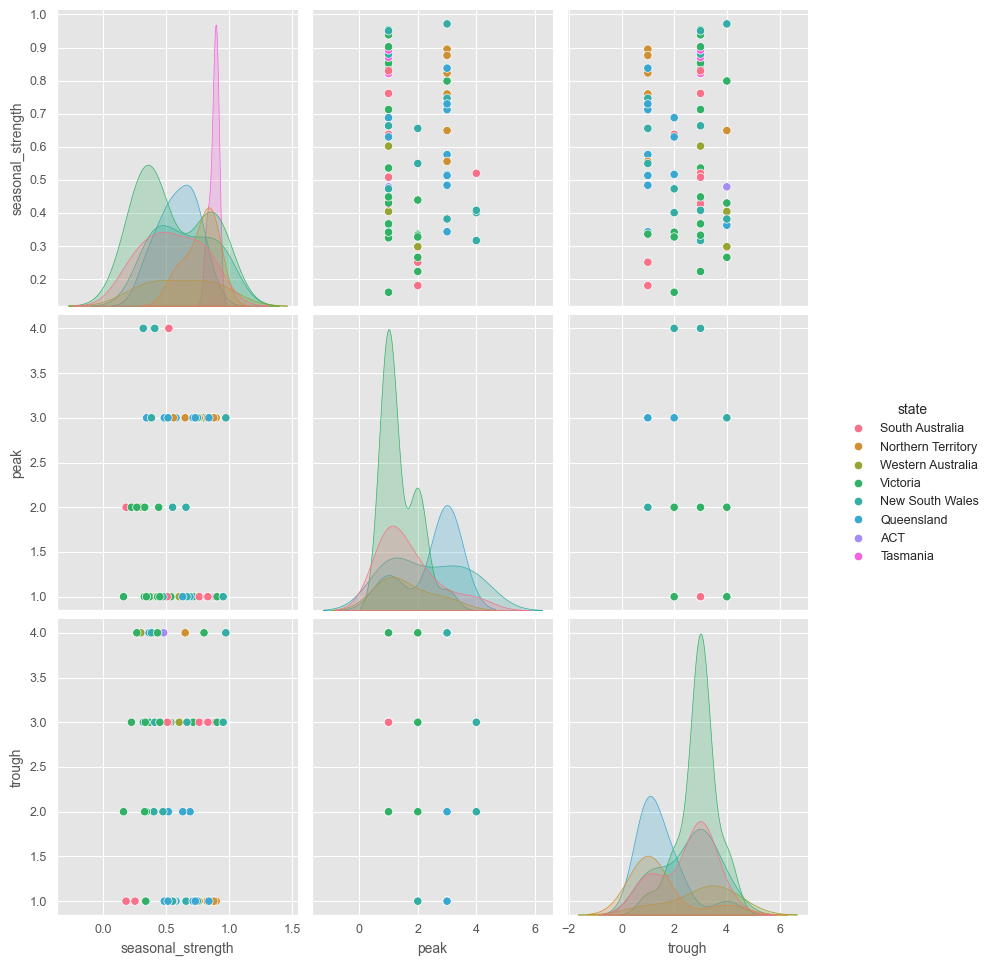

In [34]:
g = sns.pairplot(holiday_tourism[['state','seasonal_strength', 'peak', 'trough']], hue="state")
g.fig.set_size_inches(10, 10)
plt.show()